<a href="https://colab.research.google.com/github/Search-Prem/E-Waste-Generation-Classification/blob/main/E_Waste_Generation_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Week 1 work.

In [7]:
!unzip /content/sample_data/E-Waste.zip -d /content/modified-dataset/

Archive:  /content/sample_data/E-Waste.zip
  inflating: /content/modified-dataset/modified-dataset/test/Battery/battery_106.jpg  
  inflating: /content/modified-dataset/modified-dataset/test/Battery/battery_128.jpg  
  inflating: /content/modified-dataset/modified-dataset/test/Battery/battery_148.jpg  
  inflating: /content/modified-dataset/modified-dataset/test/Battery/battery_152.jpg  
  inflating: /content/modified-dataset/modified-dataset/test/Battery/battery_174.jpg  
  inflating: /content/modified-dataset/modified-dataset/test/Battery/battery_177.jpg  
  inflating: /content/modified-dataset/modified-dataset/test/Battery/battery_190.jpg  
  inflating: /content/modified-dataset/modified-dataset/test/Battery/battery_192.jpg  
  inflating: /content/modified-dataset/modified-dataset/test/Battery/battery_211.jpg  
  inflating: /content/modified-dataset/modified-dataset/test/Battery/battery_22.jpg  
  inflating: /content/modified-dataset/modified-dataset/test/Battery/battery_24.jpg  
  

In [2]:
pip install tensorflow

In [8]:
import tensorflow as tf  # Core TensorFlow library
from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks
from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models
from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning
from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet
import numpy as np  # Numerical operations and array handling
import matplotlib.pyplot as plt  # Plotting graphs and images
import seaborn as sns  # Plotting graphs and images
from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models
import gradio as gr  # Web interface library to deploy and test ML models
from PIL import Image  # For image file loading and basic image operations

In [10]:
  testpath= r'/content/modified-dataset/modified-dataset/test'
  trainpath= r'/content/modified-dataset/modified-dataset/train'
  validpath = r'/content/modified-dataset/modified-dataset/val'

In [11]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [12]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [13]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [14]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


##Visualize sample images from each class.

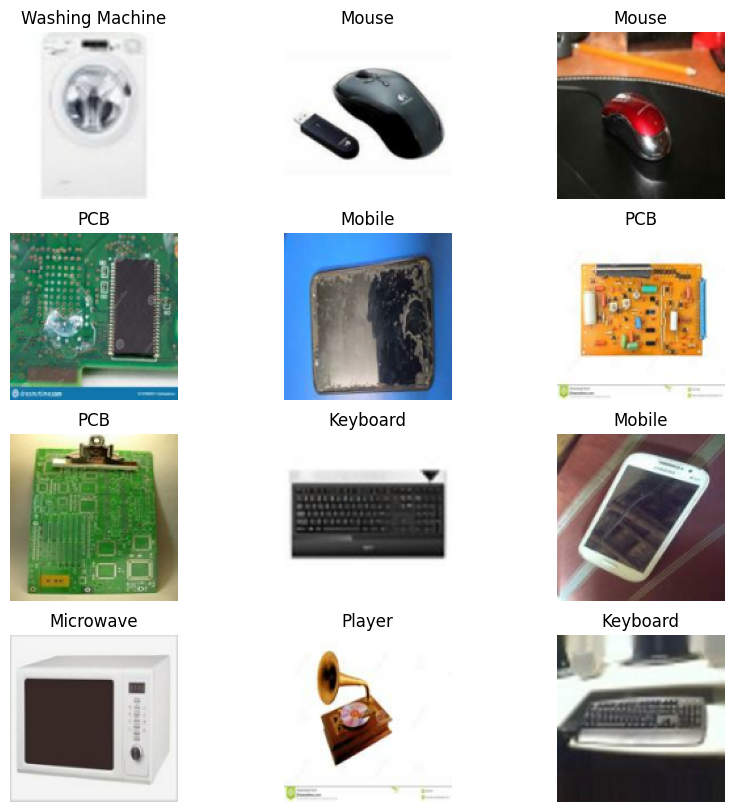

In [16]:

# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")


- ## Check the number of images per class to ensure balance
- ## Understand image properties like Image dimensions, Class labels


In [17]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    # Prepare data for plotting
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class

    # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot

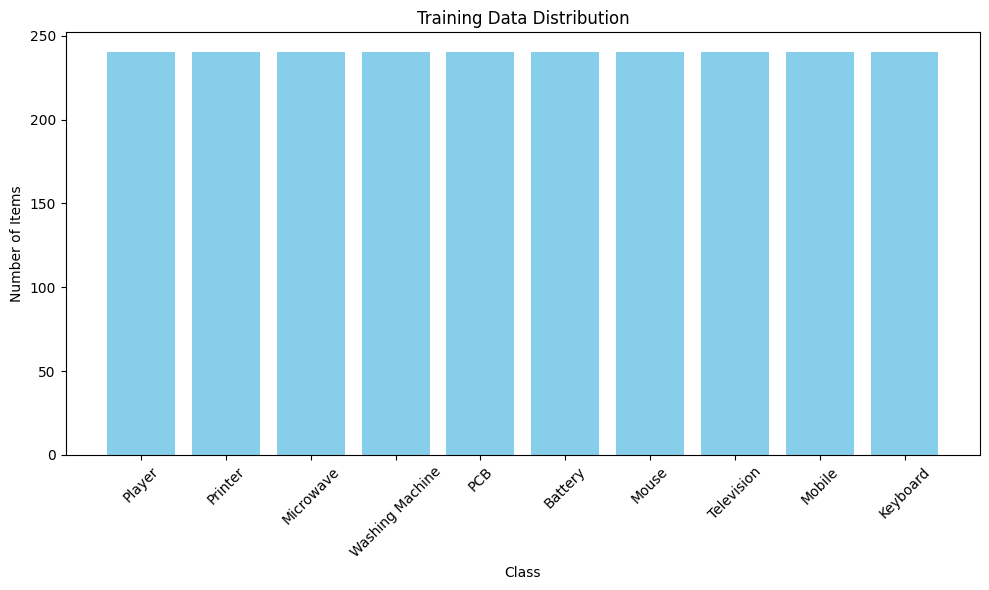

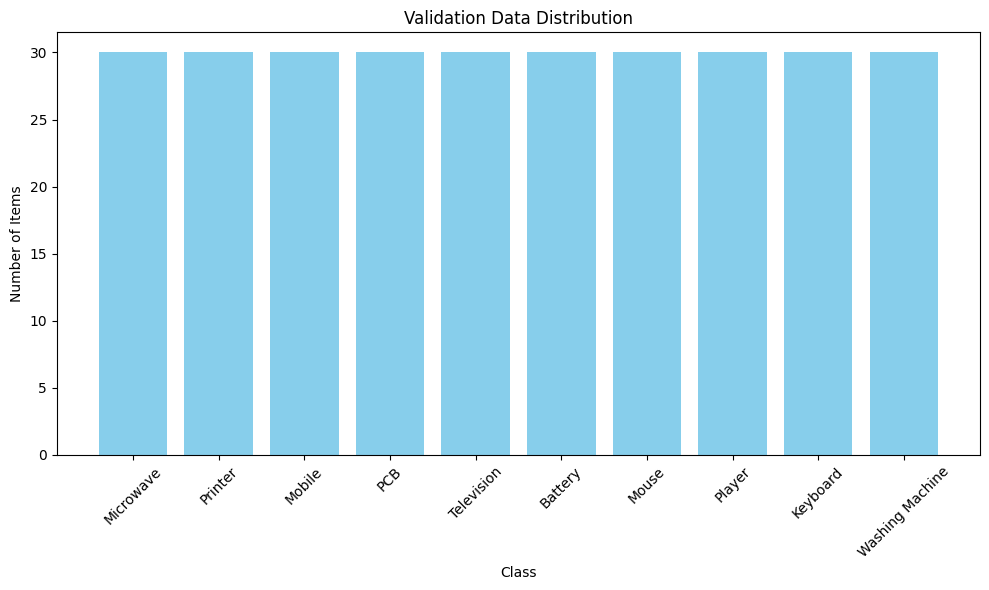

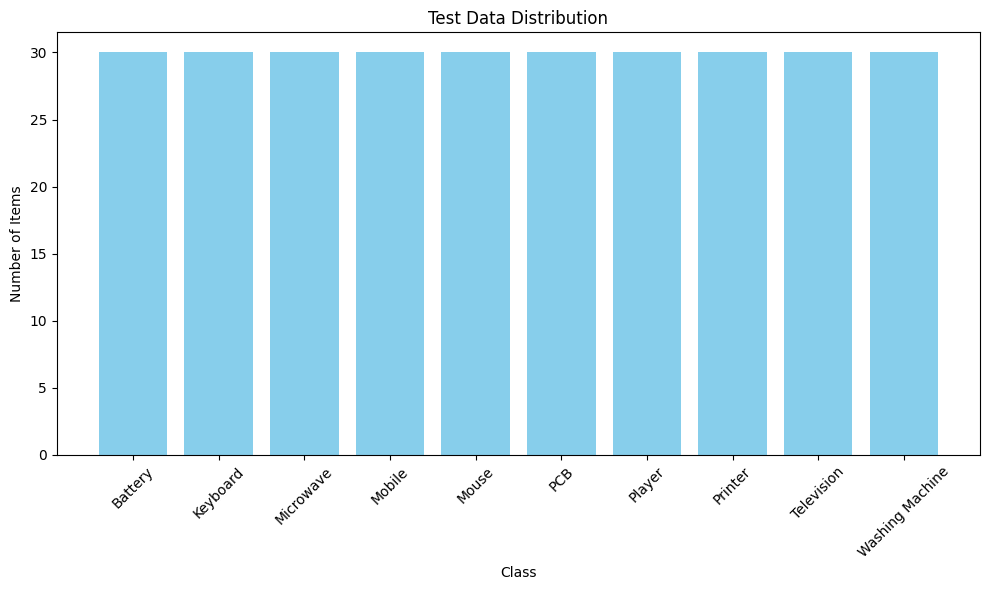

In [18]:
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

# Week 2 work


In [19]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [20]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

In [22]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)


In [24]:
# Set the number of epochs to train the model
epochs = 5

# Train the model on the training dataset 'datatrain'
history = model.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=datavalid,      # Validation data generator or dataset
    epochs=epochs,                  # Number of training epochs
    batch_size=100,                 # Number of samples per gradient update
    callbacks=[early]               # List of callbacks to apply during training (e.g., early stopping)
)


Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - Accuracy: 0.6958 - loss: 1.2916 - val_Accuracy: 0.8667 - val_loss: 0.6392
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - Accuracy: 0.8553 - loss: 0.6236 - val_Accuracy: 0.9300 - val_loss: 0.3430
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - Accuracy: 0.9006 - loss: 0.3775 - val_Accuracy: 0.9433 - val_loss: 0.2406
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - Accuracy: 0.9237 - loss: 0.2665 - val_Accuracy: 0.9567 - val_loss: 0.1958
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - Accuracy: 0.9312 - loss: 0.2138 - val_Accuracy: 0.9667 - val_loss: 0.1773


In [25]:
model.summary() # Print the architecture summary of the  model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,269,040 (62.06 MB)

 Trainable params: 5,168,458 (19.72 MB)

 Non-trainable params: 763,664 (2.91 MB)

 Optimizer params: 10,336,918 (39.43 MB)